<a href="https://colab.research.google.com/github/gayathrig269/CMPE260_Rfmt_Learning/blob/gayathrig/Part3_Neural_Network_QLearning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Neural Network to play Tic Tac Toe

To train a Neural Network to play Tic Tac Toe, the following are defined:

1. The Topology of the neural network, i.e. how do the input and output layers look like. How many hidden layers and how big?

2. A loss function. The loss function will take the output of the Neural Network and return a value indicating how good that output was.

3.     A training part which will try to adjust the weights in the Neural Network as to minimize the loss function.

##Tic Tac Toe Q-learning Graph

For the Neural Network Tic Tac Toe agnt, our graph will have the follwing things:

  1. An input layer which takes a game state, i.e. the current board, as input.
  2. One or more hidden layer.
  3. An output layer which will output the Q value for all possible moves in that game state.
  4. We use Mean Squared Error as our loss function, which is a generic and popular loss function for regression, i.e. learning to mimic another function.
  5. The input for the loss function will be the output of the Neural Network and our updated estimate of the Q function by applying the discounted rewards and maximum Q values of the next states. i.e. the loss will be the difference between the output of the Neural Network and our updated estimate of the Q function.
  6. We use the Gradient Descent Optimizer for training — i.e. to adjust the weights in the Neural Network. 
  7. We use ReLu activation function.

#Demonstration code of Neural Network Player playing TTT game starts here

In [ ]:
#Mounting the google drive contents of TIC-TAC_TOE code 
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/tic_tac_toe_master/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My\ Drive/tic_tac_toe_master/

/content/gdrive/My Drive/tic_tac_toe_master


In [ ]:
#installing the required version of Tensorflow
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 30kB/s 
     |████████████████████████████████| 3.8MB 36.9MB/s 
     |████████████████████████████████| 512kB 38.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=a2a233fb8decca297e7a65b3bddeed9442c396b293bf985a623a840bfe33afbb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

1. ReLu Activation function

In [ ]:
#
# Copyright 2017 Carsten Friedrich (Carsten.Friedrich@gmail.com). All rights reserved
#
# A trivial NN
#

import numpy as np
import tensorflow as tf
from TFSessionManager import TFSessionManager as TFSN

from Board import Board, BOARD_SIZE, EMPTY, CROSS, NAUGHT
from Player import Player, GameResult


class QNetwork:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the GradientDescentOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the GradientDescentOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor: tf.Tensor, output_size: int, activation_fn=None,
                        name: str = None) -> tf.Tensor:
        """
        Adds a dense Neural Net layer to network input_tensor
        :param input_tensor: The layer to which we should add the new layer
        :param output_size: The output size of the new layer
        :param activation_fn: The activation function for the new layer, or None if no activation function
        should be used
        :param name: The optional name of the layer. Useful for saving a loading a TensorFlow graph
        :return: A new dense layer attached to the `input_tensor`
        """
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.compat.v1.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE * 3), name='inputs')

            self.target_input = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE), name='targets')

            net = self.input_positions

            net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.relu)

            self.q_values = self.add_dense_layer(net, BOARD_SIZE, name='q_values')

            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate).minimize(mse,
                                                                                                          name='train')


class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        res = np.array([(state == self.side).astype(int),
                        (state == Board.other_side(self.side)).astype(int),
                        (state == EMPTY).astype(int)])
        return res.reshape(-1)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        super().__init__()

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board: Board) -> (GameResult, bool):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        self.board_position_log.append(board.state.copy())

        nn_input = self.board_state_to_nn_input(board.state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        for index, p in enumerate(qvalues):
            if not board.is_legal(index):
                probs[index] = -1

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int

        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        _, res, finished = board.move(move, self.side)
        return res, finished

    def final_result(self, result: GameResult):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (result == GameResult.NAUGHT_WIN and self.side == NAUGHT) or (
                result == GameResult.CROSS_WIN and self.side == CROSS):
            reward = self.win_value  # type: float
        elif (result == GameResult.NAUGHT_WIN and self.side == CROSS) or (
                result == GameResult.CROSS_WIN and self.side == NAUGHT):
            reward = self.loss_value  # type: float
        elif result == GameResult.DRAW:
            reward = self.draw_value  # type: float
        else:
            raise ValueError("Unexpected game result {}".format(result))

        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})


Testing our Neural Network player against other players

In [ ]:
from Board import Board
from util import battle
from Player import Player
from TFSessionManager import TFSessionManager
import tensorflow as tf

#Defining evaluate_players function
#This function accepts 2 players as arguemnts and plots a graph showing their performance for 100 games.
def evaluate_players(p1 : Player, p2 : Player, games_per_battle = 100, num_battles = 100,loc='best'):
    board = Board()

    p1_wins = []
    p2_wins = []
    draws = []
    game_number = []
    game_counter = 0

    TFSessionManager.set_session(tf.Session())
    TFSessionManager.get_session().run(tf.global_variables_initializer())

    for i in range (num_battles):
        p1win, p2win, draw = battle(p1, p2, games_per_battle, False)
        p1_wins.append(p1win)
        p2_wins.append(p2win)
        draws.append(draw)
        game_counter=game_counter+1
        game_number.append(game_counter)

    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(game_number, draws, 'r-', label='Draw')
    plt.plot(game_number, p1_wins, 'g-', label='Player 1 wins')
    plt.plot(game_number, p2_wins, 'b-', label='Player 2 wins')
    plt.legend(loc=loc, shadow=True, fancybox=True, framealpha =0.7)

    TFSessionManager.set_session(None)
    return game_number, p1_wins, p2_wins, draws

#1. Against the Random Player

Player 1 will be our Neural Network player, and Player 2 will be the Random Player. We assume it should be easy for the Neural Network player to win most games, but we hope it will learn to win much more than we would expect from a Random Player playing first.

After 100 game we have draws: 7, Player 1 wins: 72, and Player 2 wins: 21.
Which gives percentages of draws: 7.00%, Player 1 wins: 72.00%, and Player 2 wins:  21.00%
After 100 game we have draws: 5, Player 1 wins: 74, and Player 2 wins: 21.
Which gives percentages of draws: 5.00%, Player 1 wins: 74.00%, and Player 2 wins:  21.00%
After 100 game we have draws: 9, Player 1 wins: 73, and Player 2 wins: 18.
Which gives percentages of draws: 9.00%, Player 1 wins: 73.00%, and Player 2 wins:  18.00%
After 100 game we have draws: 8, Player 1 wins: 76, and Player 2 wins: 16.
Which gives percentages of draws: 8.00%, Player 1 wins: 76.00%, and Player 2 wins:  16.00%
After 100 game we have draws: 6, Player 1 wins: 79, and Player 2 wins: 15.
Which gives percentages of draws: 6.00%, Player 1 wins: 79.00%, and Player 2 wins:  15.00%
After 100 game we have draws: 9, Player 1 wins: 77, and Player 2 wins: 14.
Which gives percentages of draws: 9.00%, Player 1 wins: 77.00%, and Player 2 wins:  14.00%
Afte

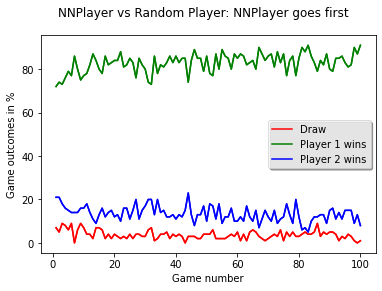

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

Since there are some non-deterministic parts in this, the results will vary to a degree, but we see the Neural Network player improve its game over time, in the end winning the vast majority of games. In particular it should win significantly more games than the Random Player. For many executions it ended up winning about 90% of games on average in the end and lose less than 10%.



Neural Network Player goes second

In [ ]:
tf.reset_default_graph()    

rndplayer = RandomPlayer() #Player1
nnplayer = NNQPlayer("QLearner1") #Player2


game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer)

plt.suptitle("NNPlayer vs Random Player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

Again, the Neural Network player improves its game over time. It typically started to beat the Random Player more often than it lost after about 20 battles and in the end would win about 80% of the games and lose around 20%.

In both cases, the player does not play draws very often. In fact they happen much less often than during pure random play.

#2. Against the (deterministic) Min Max Player 

Neural Network player goes first

After 100 game we have draws: 9, Player 1 wins: 0, and Player 2 wins: 91.
Which gives percentages of draws: 9.00%, Player 1 wins: 0.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 70, Player 1 wins: 0, and Player 2 wins: 30.
Which gives percentages of draws: 70.00%, Player 1 wins: 0.00%, and Player 2 wins:  30.00%
After 100 game we have draws: 49, Player 1 wins: 0, and Player 2 wins: 51.
Which gives percentages of draws: 49.00%, Player 1 wins: 0.00%, and Player 2 wins:  51.00%
After 100 game we have draws: 94, Player 1 wins: 0, and Player 2 wins: 6.
Which gives percentages of draws: 94.00%, Player 1 wins: 0.00%, and Player 2 wins:  6.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 10

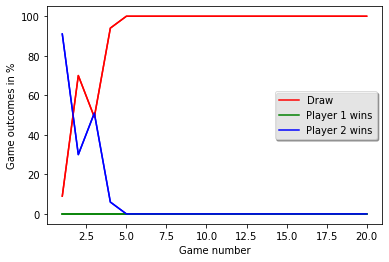

In [ ]:
from MinMaxAgent import MinMaxAgent

tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles = 20)

plt.suptitle("NNPlayer vs Min-Max (determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

Had to re-run this block of code a couple of times to see this effect. It seems that either it converges to 100% draw or 100% losses with no middle ground or change after it reached 100% of either. 

Neural Network moving second

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
Afte

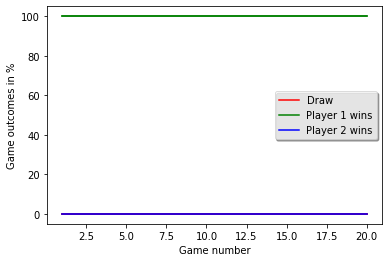

In [ ]:
tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(mm_player,nnplayer, num_battles = 20)

plt.suptitle("NNPlayer vs Min-Max (determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

It converges to 100% draws and sometime to 100% losses. 

#3. Against the non-deterministic Min Max Player

Neural Network player goes first

After 100 game we have draws: 17, Player 1 wins: 0, and Player 2 wins: 83.
Which gives percentages of draws: 17.00%, Player 1 wins: 0.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 36, Player 1 wins: 0, and Player 2 wins: 64.
Which gives percentages of draws: 36.00%, Player 1 wins: 0.00%, and Player 2 wins:  64.00%
After 100 game we have draws: 29, Player 1 wins: 0, and Player 2 wins: 71.
Which gives percentages of draws: 29.00%, Player 1 wins: 0.00%, and Player 2 wins:  71.00%
After 100 game we have draws: 30, Player 1 wins: 0, and Player 2 wins: 70.
Which gives percentages of draws: 30.00%, Player 1 wins: 0.00%, and Player 2 wins:  70.00%
After 100 game we have draws: 39, Player 1 wins: 0, and Player 2 wins: 61.
Which gives percentages of draws: 39.00%, Player 1 wins: 0.00%, and Player 2 wins:  61.00%
After 100 game we have draws: 43, Player 1 wins: 0, and Player 2 wins: 57.
Which gives percentages of draws: 43.00%, Player 1 wins: 0.00%, and Player 2 wins:  57.00%
Afte

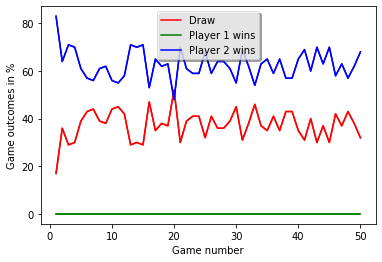

In [ ]:
from RndMinMaxAgent import RndMinMaxAgent

tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rnd_mm_player, num_battles = 50)

plt.suptitle("NNPlayer vs Min-Max (non-determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')


Observation:
Again, results are mixed. Sometimes we get close to 100% draws, but everything between 0% and 100% seems possible.

When NN Player goes second !

After 100 game we have draws: 5, Player 1 wins: 95, and Player 2 wins: 0.
Which gives percentages of draws: 5.00%, Player 1 wins: 95.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 10

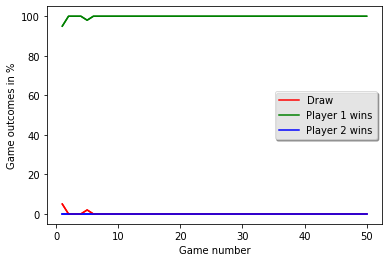

In [ ]:
tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(rnd_mm_player, nnplayer, num_battles = 50)

plt.suptitle("NNPlayer vs Min-Max (non-determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

Results are definitively not as expected; In most cases we end up playing slightly better than a random player, but not by much. Our NN Player never achieved consistently above 10% draws. 

#NN player V Tabular QL Player

NNPlayer plays first !

After 100 game we have draws: 1, Player 1 wins: 16, and Player 2 wins: 83.
Which gives percentages of draws: 1.00%, Player 1 wins: 16.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 4, Player 1 wins: 25, and Player 2 wins: 71.
Which gives percentages of draws: 4.00%, Player 1 wins: 25.00%, and Player 2 wins:  71.00%
After 100 game we have draws: 4, Player 1 wins: 25, and Player 2 wins: 71.
Which gives percentages of draws: 4.00%, Player 1 wins: 25.00%, and Player 2 wins:  71.00%
After 100 game we have draws: 3, Player 1 wins: 11, and Player 2 wins: 86.
Which gives percentages of draws: 3.00%, Player 1 wins: 11.00%, and Player 2 wins:  86.00%
After 100 game we have draws: 6, Player 1 wins: 11, and Player 2 wins: 83.
Which gives percentages of draws: 6.00%, Player 1 wins: 11.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 4, Player 1 wins: 7, and Player 2 wins: 89.
Which gives percentages of draws: 4.00%, Player 1 wins: 7.00%, and Player 2 wins:  89.00%
After 

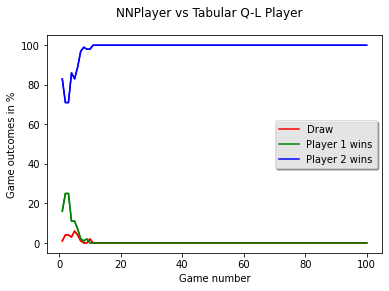

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, tqplayer)


plt.suptitle("NNPlayer vs Tabular Q-L Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:


NNPlayer at the max, wins 30% of the first few battles, but TQ Player quickly picks up and wins 100% of the time beyond 15 battles.

NN Player plays second

After 100 game we have draws: 14, Player 1 wins: 81, and Player 2 wins: 5.
Which gives percentages of draws: 14.00%, Player 1 wins: 81.00%, and Player 2 wins:  5.00%
After 100 game we have draws: 7, Player 1 wins: 90, and Player 2 wins: 3.
Which gives percentages of draws: 7.00%, Player 1 wins: 90.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 6, Player 1 wins: 94, and Player 2 wins: 0.
Which gives percentages of draws: 6.00%, Player 1 wins: 94.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 

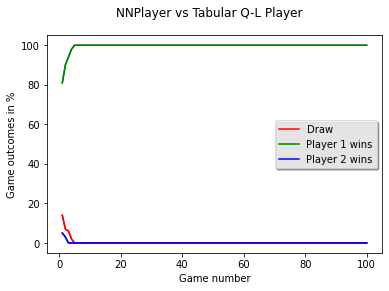

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(tqplayer,nnplayer)


plt.suptitle("NNPlayer vs Tabular Q-L Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

As expected NNPlayer performs worse than when it played first. At its best,it draws 18% of the first few battles, before TQPlayer catches up and wins 100% of the time for the next 95 battles. 

#Other activation functions experimented:

We have experimented with the following **activation** functions:
1. tanh
2. leaky ReLu
3. sigmoid

Apart from Gradient descent optimzer, we have experimented with the  **Adam optimizer.**

# Activation functions

1. tanh activation function

In [ ]:
#
# Copyright 2017 Carsten Friedrich (Carsten.Friedrich@gmail.com). All rights reserved
#
# Very trivial NN, but already learns and wins more than it loses against Random Player
#

import numpy as np
import tensorflow as tf
from TFSessionManager import TFSessionManager as TFSN

from Board import Board, BOARD_SIZE, EMPTY, CROSS, NAUGHT
from Player import Player, GameResult


class QNetwork:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the GradientDescentOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the GradientDescentOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor: tf.Tensor, output_size: int, activation_fn=None,
                        name: str = None) -> tf.Tensor:
        """
        Adds a dense Neural Net layer to network input_tensor
        :param input_tensor: The layer to which we should add the new layer
        :param output_size: The output size of the new layer
        :param activation_fn: The activation function for the new layer, or None if no activation function
        should be used
        :param name: The optional name of the layer. Useful for saving a loading a TensorFlow graph
        :return: A new dense layer attached to the `input_tensor`
        """
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE * 3), name='inputs')

            self.target_input = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE), name='targets')

            net = self.input_positions

            net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.tanh)

            self.q_values = self.add_dense_layer(net, BOARD_SIZE, name='q_values')

            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate).minimize(mse,
                                                                                                          name='train')


class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        res = np.array([(state == self.side).astype(int),
                        (state == Board.other_side(self.side)).astype(int),
                        (state == EMPTY).astype(int)])
        return res.reshape(-1)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        super().__init__()

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board: Board) -> (GameResult, bool):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        self.board_position_log.append(board.state.copy())

        nn_input = self.board_state_to_nn_input(board.state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        for index, p in enumerate(qvalues):
            if not board.is_legal(index):
                probs[index] = -1

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int

        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        _, res, finished = board.move(move, self.side)
        return res, finished

    def final_result(self, result: GameResult):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (result == GameResult.NAUGHT_WIN and self.side == NAUGHT) or (
                result == GameResult.CROSS_WIN and self.side == CROSS):
            reward = self.win_value  # type: float
        elif (result == GameResult.NAUGHT_WIN and self.side == CROSS) or (
                result == GameResult.CROSS_WIN and self.side == NAUGHT):
            reward = self.loss_value  # type: float
        elif result == GameResult.DRAW:
            reward = self.draw_value  # type: float
        else:
            raise ValueError("Unexpected game result {}".format(result))

        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})


2. Leaky ReLu activation function

In [ ]:
#
# Copyright 2017 Carsten Friedrich (Carsten.Friedrich@gmail.com). All rights reserved
#
# Very trivial NN, but already learns and wins more than it loses against Random Player
#

import numpy as np
import tensorflow as tf
from TFSessionManager import TFSessionManager as TFSN

from Board import Board, BOARD_SIZE, EMPTY, CROSS, NAUGHT
from Player import Player, GameResult


class QNetwork:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the GradientDescentOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the GradientDescentOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor: tf.Tensor, output_size: int, activation_fn=None,
                        name: str = None) -> tf.Tensor:
        """
        Adds a dense Neural Net layer to network input_tensor
        :param input_tensor: The layer to which we should add the new layer
        :param output_size: The output size of the new layer
        :param activation_fn: The activation function for the new layer, or None if no activation function
        should be used
        :param name: The optional name of the layer. Useful for saving a loading a TensorFlow graph
        :return: A new dense layer attached to the `input_tensor`
        """
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE * 3), name='inputs')

            self.target_input = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE), name='targets')

            net = self.input_positions

            net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.leaky_relu)

            self.q_values = self.add_dense_layer(net, BOARD_SIZE, name='q_values')

            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate).minimize(mse,
                                                                                                          name='train')


class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        res = np.array([(state == self.side).astype(int),
                        (state == Board.other_side(self.side)).astype(int),
                        (state == EMPTY).astype(int)])
        return res.reshape(-1)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        super().__init__()

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board: Board) -> (GameResult, bool):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        self.board_position_log.append(board.state.copy())

        nn_input = self.board_state_to_nn_input(board.state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        for index, p in enumerate(qvalues):
            if not board.is_legal(index):
                probs[index] = -1

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int

        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        _, res, finished = board.move(move, self.side)
        return res, finished

    def final_result(self, result: GameResult):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (result == GameResult.NAUGHT_WIN and self.side == NAUGHT) or (
                result == GameResult.CROSS_WIN and self.side == CROSS):
            reward = self.win_value  # type: float
        elif (result == GameResult.NAUGHT_WIN and self.side == CROSS) or (
                result == GameResult.CROSS_WIN and self.side == NAUGHT):
            reward = self.loss_value  # type: float
        elif result == GameResult.DRAW:
            reward = self.draw_value  # type: float
        else:
            raise ValueError("Unexpected game result {}".format(result))

        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})


3. sigmoid activation function

In [ ]:
#
# Copyright 2017 Carsten Friedrich (Carsten.Friedrich@gmail.com). All rights reserved
#
# Very trivial NN, but already learns and wins more than it loses against Random Player
#

import numpy as np
import tensorflow as tf
from TFSessionManager import TFSessionManager as TFSN

from Board import Board, BOARD_SIZE, EMPTY, CROSS, NAUGHT
from Player import Player, GameResult


class QNetwork:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the GradientDescentOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the GradientDescentOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor: tf.Tensor, output_size: int, activation_fn=None,
                        name: str = None) -> tf.Tensor:
        """
        Adds a dense Neural Net layer to network input_tensor
        :param input_tensor: The layer to which we should add the new layer
        :param output_size: The output size of the new layer
        :param activation_fn: The activation function for the new layer, or None if no activation function
        should be used
        :param name: The optional name of the layer. Useful for saving a loading a TensorFlow graph
        :return: A new dense layer attached to the `input_tensor`
        """
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE * 3), name='inputs')

            self.target_input = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE), name='targets')

            net = self.input_positions

            net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.sigmoid)

            self.q_values = self.add_dense_layer(net, BOARD_SIZE, name='q_values')

            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate).minimize(mse,
                                                                                                          name='train')


class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        res = np.array([(state == self.side).astype(int),
                        (state == Board.other_side(self.side)).astype(int),
                        (state == EMPTY).astype(int)])
        return res.reshape(-1)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        super().__init__()

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board: Board) -> (GameResult, bool):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        self.board_position_log.append(board.state.copy())

        nn_input = self.board_state_to_nn_input(board.state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        for index, p in enumerate(qvalues):
            if not board.is_legal(index):
                probs[index] = -1

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int

        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        _, res, finished = board.move(move, self.side)
        return res, finished

    def final_result(self, result: GameResult):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (result == GameResult.NAUGHT_WIN and self.side == NAUGHT) or (
                result == GameResult.CROSS_WIN and self.side == CROSS):
            reward = self.win_value  # type: float
        elif (result == GameResult.NAUGHT_WIN and self.side == CROSS) or (
                result == GameResult.CROSS_WIN and self.side == NAUGHT):
            reward = self.loss_value  # type: float
        elif result == GameResult.DRAW:
            reward = self.draw_value  # type: float
        else:
            raise ValueError("Unexpected game result {}".format(result))

        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})


After 100 game we have draws: 12, Player 1 wins: 66, and Player 2 wins: 22.
Which gives percentages of draws: 12.00%, Player 1 wins: 66.00%, and Player 2 wins:  22.00%
After 100 game we have draws: 11, Player 1 wins: 67, and Player 2 wins: 22.
Which gives percentages of draws: 11.00%, Player 1 wins: 67.00%, and Player 2 wins:  22.00%
After 100 game we have draws: 8, Player 1 wins: 79, and Player 2 wins: 13.
Which gives percentages of draws: 8.00%, Player 1 wins: 79.00%, and Player 2 wins:  13.00%
After 100 game we have draws: 5, Player 1 wins: 79, and Player 2 wins: 16.
Which gives percentages of draws: 5.00%, Player 1 wins: 79.00%, and Player 2 wins:  16.00%
After 100 game we have draws: 8, Player 1 wins: 67, and Player 2 wins: 25.
Which gives percentages of draws: 8.00%, Player 1 wins: 67.00%, and Player 2 wins:  25.00%
After 100 game we have draws: 6, Player 1 wins: 81, and Player 2 wins: 13.
Which gives percentages of draws: 6.00%, Player 1 wins: 81.00%, and Player 2 wins:  13.00%


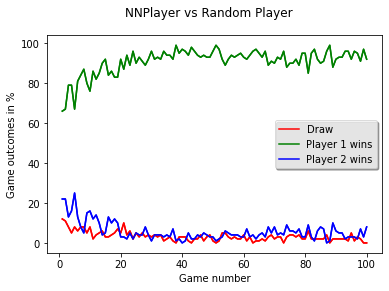

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

#Adam Optimizer

In [ ]:
#
# Copyright 2017 Carsten Friedrich (Carsten.Friedrich@gmail.com). All rights reserved
#


import numpy as np
import tensorflow as tf
from TFSessionManager import TFSessionManager as TFSN

from Board import Board, BOARD_SIZE, EMPTY, CROSS, NAUGHT
from Player import Player, GameResult


class QNetwork:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the AdamOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the AdamOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor: tf.Tensor, output_size: int, activation_fn=None,
                        name: str = None) -> tf.Tensor:
        """
        Adds a dense Neural Net layer to network input_tensor
        :param input_tensor: The layer to which we should add the new layer
        :param output_size: The output size of the new layer
        :param activation_fn: The activation function for the new layer, or None if no activation function
        should be used
        :param name: The optional name of the layer. Useful for saving a loading a TensorFlow graph
        :return: A new dense layer attached to the `input_tensor`
        """
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE * 3), name='inputs')

            self.target_input = tf.placeholder(tf.float32, shape=(None, BOARD_SIZE), name='targets')

            net = self.input_positions

            net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.sigmoid)

            self.q_values = self.add_dense_layer(net, BOARD_SIZE, name='q_values')

            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.AdamOptimizer(learning_rate=self.learningRate).minimize(mse,
                                                                                                          name='train')


class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        res = np.array([(state == self.side).astype(int),
                        (state == Board.other_side(self.side)).astype(int),
                        (state == EMPTY).astype(int)])
        return res.reshape(-1)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        super().__init__()

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board: Board) -> (GameResult, bool):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        self.board_position_log.append(board.state.copy())

        nn_input = self.board_state_to_nn_input(board.state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        for index, p in enumerate(qvalues):
            if not board.is_legal(index):
                probs[index] = -1

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int

        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        _, res, finished = board.move(move, self.side)
        return res, finished

    def final_result(self, result: GameResult):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (result == GameResult.NAUGHT_WIN and self.side == NAUGHT) or (
                result == GameResult.CROSS_WIN and self.side == CROSS):
            reward = self.win_value  # type: float
        elif (result == GameResult.NAUGHT_WIN and self.side == CROSS) or (
                result == GameResult.CROSS_WIN and self.side == NAUGHT):
            reward = self.loss_value  # type: float
        elif result == GameResult.DRAW:
            reward = self.draw_value  # type: float
        else:
            raise ValueError("Unexpected game result {}".format(result))

        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})


After 100 game we have draws: 0, Player 1 wins: 14, and Player 2 wins: 86.
Which gives percentages of draws: 0.00%, Player 1 wins: 14.00%, and Player 2 wins:  86.00%
After 100 game we have draws: 4, Player 1 wins: 5, and Player 2 wins: 91.
Which gives percentages of draws: 4.00%, Player 1 wins: 5.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 0, Player 1 wins: 9, and Player 2 wins: 91.
Which gives percentages of draws: 0.00%, Player 1 wins: 9.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 1, Player 1 wins: 11, and Player 2 wins: 88.
Which gives percentages of draws: 1.00%, Player 1 wins: 11.00%, and Player 2 wins:  88.00%
After 100 game we have draws: 2, Player 1 wins: 2, and Player 2 wins: 96.
Which gives percentages of draws: 2.00%, Player 1 wins: 2.00%, and Player 2 wins:  96.00%
After 100 game we have draws: 2, Player 1 wins: 1, and Player 2 wins: 97.
Which gives percentages of draws: 2.00%, Player 1 wins: 1.00%, and Player 2 wins:  97.00%
After 100 ga

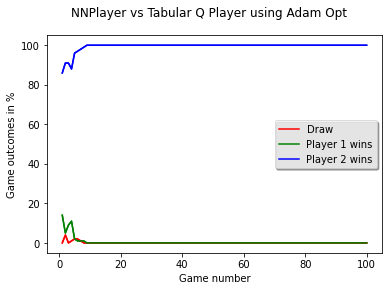

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tbqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, tbqplayer)


plt.suptitle("NNPlayer vs Tabular Q Player using Adam Opt")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

#Summary

The summary of our results with this very simple Neural Network based player:

Player      |  NN Player 1st          |  NN Player 2nd  
==============================================================
Random      | Not bad but not perfect | Kind of but not really
Min Max     | Mixed — All or nothing  | Mixed — All or nothing
Rnd Min Max | Sometimes / Mixed       | Nope

#Conclusion

Observed minor changes in the graphs after using tanh,Leaky ReLu as the activation functions.
 